<a href="https://colab.research.google.com/github/likw99/awesome_colab/blob/main/Lamini_Finetuning_for_Free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

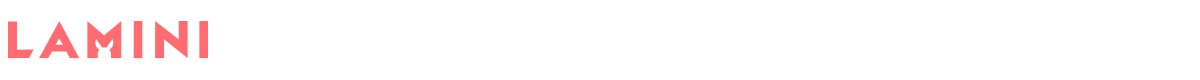

# [Lamini](https://www.lamini.ai/): The LLM engine for rapidly customizing models 🦙
Walk through Lamini's finetuning pipeline, so you can train custom models on your data.

- It's free at $0 per training run.
- It's fast at less than 15 minutes.
- It's similar to a nearly unlimited prompt size. The toy example here takes in ~120k tokens, more than the largest prompt sizes.
- It's learning new information, not just trying to make sense of it given what it already learned (retrieval-augmented generation).


This walkthrough goes through a basic question-answer LLM over your data.

# Setup 🛠️

In [ ]:
# @title Step 1: Authenticate with Google
# @markdown Note: You will be asked to sign in with Google, connected to your Lamini account.

from google.colab import auth
import requests
import os
import yaml

def authenticate_powerml():
  auth.authenticate_user()
  gcloud_token = !gcloud auth print-access-token
  powerml_token_response = requests.get('https://api.powerml.co/v1/auth/verify_gcloud_token?token=' + gcloud_token[0])
  print(powerml_token_response)
  return powerml_token_response.json()['token']

key = authenticate_powerml()

config = {
    "production": {
        "key": key,
        "url": "https://api.powerml.co"
    }
}

keys_dir_path = '/root/.powerml'
os.makedirs(keys_dir_path, exist_ok=True)

keys_file_path = keys_dir_path + '/configure_llama.yaml'
with open(keys_file_path, 'w') as f:
  yaml.dump(config, f, default_flow_style=False)


<Response [200]>


In [ ]:
# @title Step 2: Install the open-source [Lamini library](https://pypi.org/project/lamini/) to use LLMs easily
# @markdown Note: After installing, click the "RESTART RUNTIME" button at the end of the output, then go onto the next cell.
# @markdown Lamini is just on a more recent version of numpy than Colab.
!pip install --upgrade --force-reinstall --ignore-installed lamini==0.0.19

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ...

# Prepare your data 📊

Upload your question-answer data in the following format (jsonl):
```
{"question": "type your question", "answer": "answer to the question"}

```
Upload your question-answer data in the following format (csv):
```
Make sure that you have 'question' and 'answer' as column keys

```
You can also download a sample `seed_lamini_docs.jsonl` file, with Lamini question-answer data in it 🦙

Also we have some more example related to Taylor Swift &nbsp;👑, BTS &nbsp;💜, and Open LLMs &nbsp;📚, try it out!

In [ ]:
!wget -q -O "seed_lamini_docs.jsonl" "https://drive.google.com/uc?export=download&id=1SfGp1tVuLTs0WYDugZcxX-EHrmDtYrYJ"
!wget -q -O "seed_taylor_swift.jsonl" "https://drive.google.com/uc?export=download&id=119sHYYImcXEbGyvS3wWGpkSEVIFdLy6Z"
!wget -q -O "seed_bts.csv" "https://drive.google.com/uc?export=download&id=1lblhdhKwoiOjlvfk8tr7Ieo4KpvjRm6n"
!wget -q -O "seed_open_llm.jsonl" "https://drive.google.com/uc?export=download&id=1S7oPPko-UmOr-bqkZ_PREfGKO2f73ZiK"

In [ ]:
# Functions for printing results during training...
def print_training_results(results):
    print("-"*100)
    print("Training Results")
    print(results)
    print("-"*100)

# ...and after training (inference/runtime)
def print_inference(question, finetune_answer, base_answer):
    print('Running Inference for: '+ question)
    print("-"*100)
    print("Finetune model answer: ", finetune_answer)
    print("-"*100)
    print("Base model answer: ", base_answer)
    print("-"*100)

# Finetune your LLM 🦙

Finetuning has a simple interface. The basic premise is:
1. Instantiate the LLM

```
    from llama import QuestionAnswerModel
    model = QuestionAnswerModel()
```
2. Load your data into the LLM

```
    model.load_question_answer_from_jsonlines("seed_lamini_docs.jsonl")

```
```
    model.load_question_answer_from_csv("seed_bts.csv")

```
3. Train the LLM

```
    model.train()

```

4. Compare your LLM: before and after training (optional)

```
    results = model.get_eval_results()

```

5. Run your trained LLM

```
    answer = model.get_answer("How can I add data to Lamini?")
```

In [ ]:
from llama import QuestionAnswerModel
import time

# Instantiate the model and load the data into it
finetune_model = QuestionAnswerModel()
finetune_model.load_question_answer_from_jsonlines("seed_lamini_docs.jsonl")

# Model Support 🤗
To use different models for finetuning, you can pass in model_name parameter to QuestionAnswerModel(), for example:
```
  model = QuestionAnswerModel(model_name="YOUR_MODEL_NAME")
```
Currently the free tier version supports limited models, you can find the list [here](https://lamini-ai.github.io/notebooks/#lamini-finetuning-for-free).

In [ ]:
# Train the model
start=time.time()
finetune_model.train()
print(f"Time taken: {time.time()-start} seconds")

Training job submitted! Check status of job 2061 here: https://app.lamini.ai/train
Finetuning process completed, model name is: 79eeddaeda6522144c40efbf9157493672c68851d580ac2a1f7315d84cf35231
Time taken: 309.2425570487976 seconds


# See the results 🔮
Once the model finishes training, you can view its responses, chat, and compare it to the base model on https://app.lamini.ai/train 👈

More details on the finetune model vs base model are below 👇

In [ ]:
# Evaluate base and finetuned models to compare performance
results = finetune_model.get_eval_results()
print_training_results(results)

----------------------------------------------------------------------------------------------------
Training Results
{'job_id': 2061, 'eval_results': [{'input': 'What can the `check_job_status()` function tell me about the progress of a task in Lamini? How do I use it to track the status of a job?', 'outputs': [{'model_name': '79eeddaeda6522144c40efbf9157493672c68851d580ac2a1f7315d84cf35231', 'output': ' The `check_job_status()` method in Lamini is a powerful tool for tracking progress and monitoring progress. It can be used to monitor the status of a job, and can also be used to update the status of the job as it progresses.'}]}, {'input': 'What kind of results can I expect to get from the `get_job_result()` function in Lamini? How can I use those results effectively?', 'outputs': [{'model_name': '79eeddaeda6522144c40efbf9157493672c68851d580ac2a1f7315d84cf35231', 'output': ' The `get_job_result()` method in Lamini is a powerful tool for generating text outputs for various tasks. It c

## Congratulations, you've finetuned an LLM 🎉

As you can see, the base model is really off the rails. Meanwhile, finetuning got the LLM to answer the question correctly and coherently!

## Thanks for the tiny LLM, I'm ready for the real deal 💪
If you want to build larger LLMs, run this live in production, host this on your own infrastructure (e.g. VPC or on premise), or other enterprise features, [please contact us](https://www.lamini.ai/contact).